In [1]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import json 

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]
db.list_collection_names()

['fs.files', 'feat_30', 'fs.chunks', 'feat_3']

In [3]:
# Select 'feat_3' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
1,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
2,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [4]:
# Select 'feat_30' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [5]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [6]:
# identify path for images
images_path = "Data/images_original/"

In [7]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [8]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

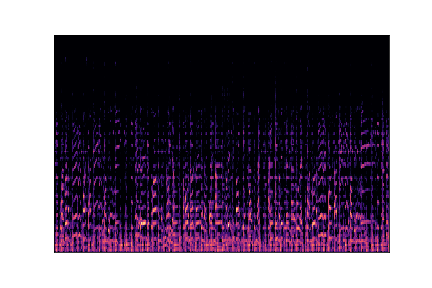

In [9]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

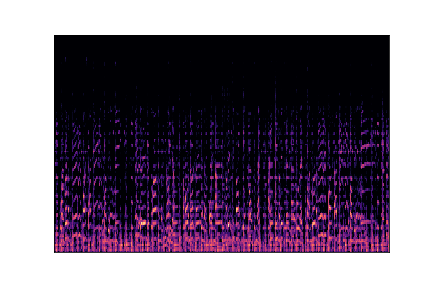

In [10]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")
rgb_test

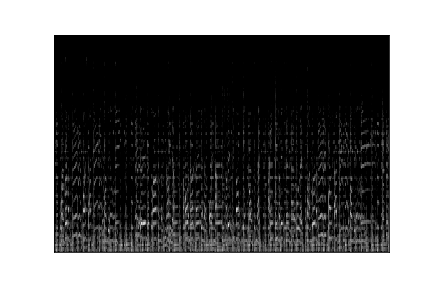

In [11]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [12]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [13]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

# Supervised Machine Learning Models to Predict `label` from feature data

In [14]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [15]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
1,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
2,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [16]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## `RandomForestClassifier`
### `features_3_sec.csv`

In [18]:
# Instantiate the model
rf_3_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                  max_features="auto", max_depth=40, bootstrap=False)  # CHANGEABLE for bar plot comparisons

# Fit the model
rf_3_model = rf_3_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_3_pred = rf_3_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_3_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,0,0
4,6,9
...,...,...
2493,1,1
2494,3,3
2495,2,2
2496,0,0


In [19]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_3_pred)
cm

array([[221,   0,   4,   4,   1,   3,   3,   0,   0,   0],
       [  0, 240,   2,   0,   0,   4,   0,   0,   0,   1],
       [ 10,   2, 236,   2,   0,   7,   1,   0,   5,   0],
       [  5,   4,   4, 201,   3,   0,   1,   2,   4,   5],
       [  0,   1,   2,   9, 232,   0,   2,  10,   2,   4],
       [  5,   9,   8,   2,   0, 227,   0,   0,   0,   0],
       [  1,   0,   1,   2,   5,   0, 239,   0,   1,  10],
       [  0,   2,   9,   5,   4,   0,   0, 215,   5,   2],
       [  1,   2,   8,   2,   4,   2,   0,   7, 238,   1],
       [  7,   3,   7,  11,   0,   7,  12,   0,   5, 192]])

Text(107.5, 0.5, 'True')

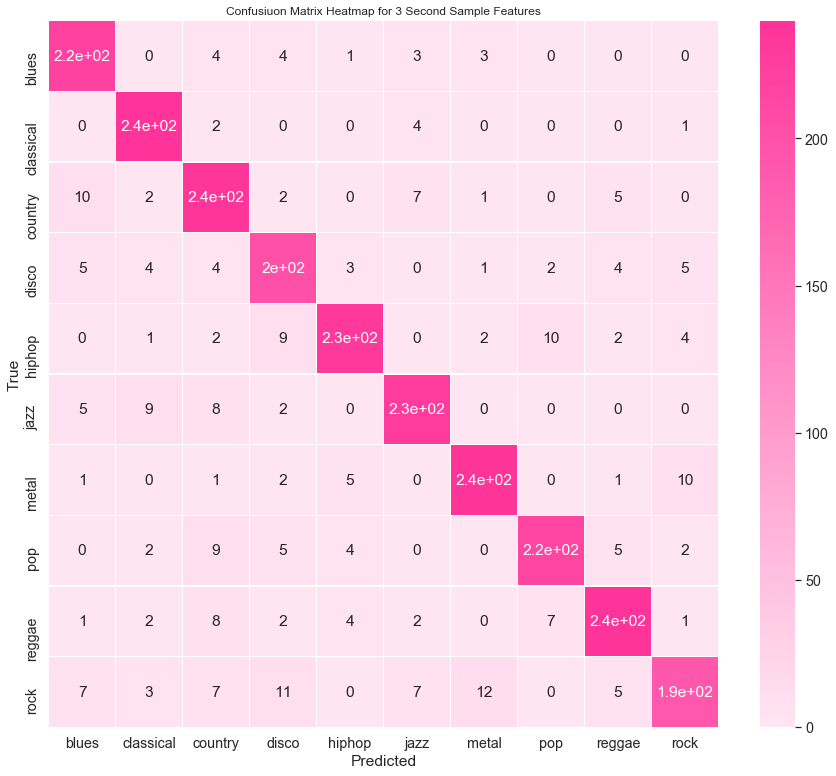

In [21]:
sortedlabels = genre_nums.keys()
cm_df = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)

sns.set(font_scale=1.3)
sns.heatmap(cm_df, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 3 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [22]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_3_pred)
acc_score

0.8971176941553243

In [23]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_3_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       236
           1       0.91      0.97      0.94       247
           2       0.84      0.90      0.87       263
           3       0.84      0.88      0.86       229
           4       0.93      0.89      0.91       262
           5       0.91      0.90      0.91       251
           6       0.93      0.92      0.92       259
           7       0.92      0.89      0.90       242
           8       0.92      0.90      0.91       265
           9       0.89      0.79      0.84       244

    accuracy                           0.90      2498
   macro avg       0.90      0.90      0.90      2498
weighted avg       0.90      0.90      0.90      2498



In [24]:
classification_report_3_second = sklearn.metrics.classification_report(y_test, rf_3_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_3_second[str(i)]
total_accuracy = classification_report_3_second["accuracy"]
common_metrics = {"macro avg": classification_report_3_second["macro avg"],
                  "weighted avg": classification_report_3_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [25]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.8971176941553243


In [27]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_Metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [28]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [29]:
# Most important features
# List in descending order by feature importance
importances = rf_3_model.feature_importances_
sorted(zip(importances, X), reverse=True)

[(0.05313858408126848, 'perceptr_var'),
 (0.03796319379244797, 'rms_var'),
 (0.03654913256115789, 'chroma_stft_mean'),
 (0.03380057802425955, 'rms_mean'),
 (0.032779540254895156, 'mfcc4_mean'),
 (0.03184314733213713, 'spectral_bandwidth_mean'),
 (0.029242517219886643, 'perceptr_mean'),
 (0.028405526056882326, 'mfcc1_mean'),
 (0.026808912262234877, 'harmony_var'),
 (0.025897576890129347, 'rolloff_mean'),
 (0.023326316960102574, 'mfcc1_var'),
 (0.022726515736156437, 'mfcc9_mean'),
 (0.022336886329051762, 'rolloff_var'),
 (0.022244265245066668, 'harmony_mean'),
 (0.02223966360693594, 'spectral_centroid_mean'),
 (0.022125099350496755, 'mfcc6_mean'),
 (0.02085286102341994, 'spectral_centroid_var'),
 (0.020359430506634583, 'mfcc3_mean'),
 (0.01923968886766487, 'zero_crossing_rate_mean'),
 (0.019194289210696047, 'mfcc8_mean'),
 (0.018324601721090548, 'mfcc5_var'),
 (0.017897523609478088, 'mfcc2_mean'),
 (0.017543434118986435, 'chroma_stft_var'),
 (0.01747453608786685, 'mfcc12_mean'),
 (0.0172

### `features_30_sec.csv`

In [30]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [31]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [32]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [33]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [34]:
# Instantiate the model
rf_30_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                  max_features="auto", max_depth=40, bootstrap=False) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,8,8
2,2,2
3,5,5
4,6,6
...,...,...
245,4,4
246,9,3
247,9,0
248,4,4


In [35]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)
cm

array([[16,  0,  0,  0,  0,  1,  1,  0,  1,  2],
       [ 1, 13,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 3,  0, 18,  4,  0,  2,  0,  0,  0,  3],
       [ 0,  0,  2, 13,  6,  0,  0,  0,  3,  2],
       [ 2,  0,  0,  0, 16,  0,  1,  1,  7,  1],
       [ 0,  3,  1,  1,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0, 24,  0,  1,  0],
       [ 0,  0,  0,  1,  1,  0,  0, 21,  1,  2],
       [ 1,  0,  0,  0,  4,  0,  0,  2, 10,  3],
       [ 2,  0,  3,  6,  1,  1,  2,  0,  0, 15]])

Text(107.5, 0.5, 'True')

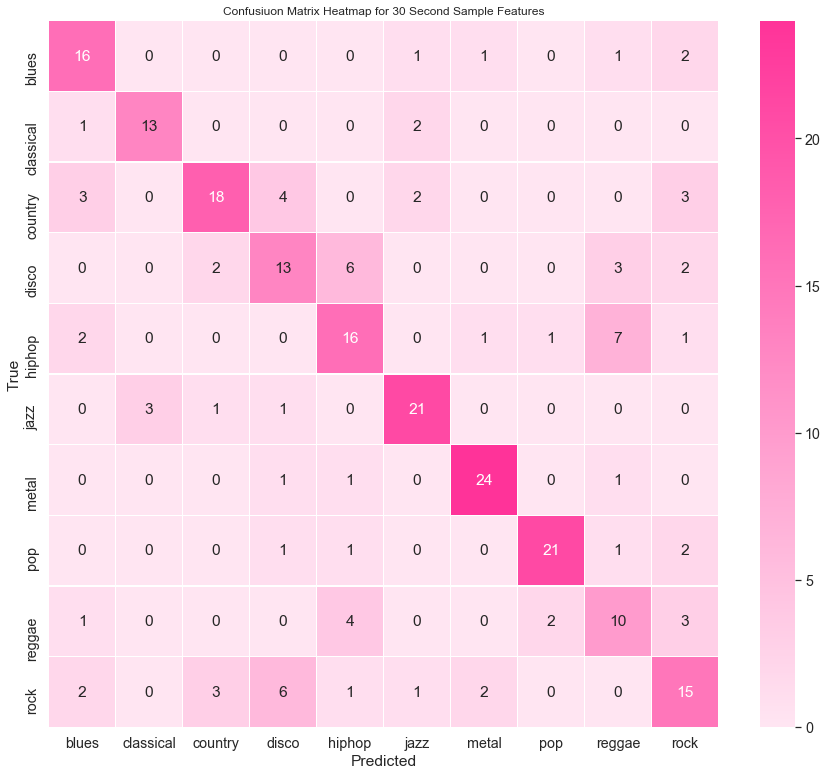

In [36]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.3)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 30 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [37]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.668

In [38]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.81      0.81      0.81        16
           2       0.75      0.60      0.67        30
           3       0.50      0.50      0.50        26
           4       0.55      0.57      0.56        28
           5       0.78      0.81      0.79        26
           6       0.86      0.89      0.87        27
           7       0.88      0.81      0.84        26
           8       0.43      0.50      0.47        20
           9       0.54      0.50      0.52        30

    accuracy                           0.67       250
   macro avg       0.67      0.68      0.67       250
weighted avg       0.67      0.67      0.67       250



In [39]:
classification_report_30_second = sklearn.metrics.classification_report(y_test, rf_30_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_30_second[str(i)]
total_accuracy = classification_report_30_second["accuracy"]
common_metrics = {"macro avg": classification_report_30_second["macro avg"],
                  "weighted avg": classification_report_30_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [40]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.668


In [41]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [42]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [43]:
# Most important features
# List in descending order by feature importance
importances = rf_30_model.feature_importances_
sorted(zip(importances, X), reverse=True)

[(0.048030641789688924, 'perceptr_var'),
 (0.04566409310456823, 'chroma_stft_mean'),
 (0.03391064761277132, 'rms_mean'),
 (0.03338121723640303, 'rms_var'),
 (0.03060959893003382, 'chroma_stft_var'),
 (0.02920338985478387, 'mfcc4_mean'),
 (0.027283205343642605, 'mfcc1_mean'),
 (0.02726711795520732, 'harmony_var'),
 (0.02674511925588522, 'spectral_bandwidth_mean'),
 (0.026645172739778258, 'rolloff_mean'),
 (0.02368752669856963, 'spectral_centroid_var'),
 (0.023262252686376935, 'mfcc5_var'),
 (0.020389065228120305, 'spectral_centroid_mean'),
 (0.019703881829474263, 'rolloff_var'),
 (0.018956739016011127, 'mfcc9_mean'),
 (0.0187798713420566, 'perceptr_mean'),
 (0.018532597001924365, 'mfcc4_var'),
 (0.0183828962757156, 'mfcc20_var'),
 (0.01832631165054814, 'mfcc12_mean'),
 (0.01820929010284642, 'zero_crossing_rate_mean'),
 (0.01789979120410054, 'mfcc1_var'),
 (0.017889915821439038, 'mfcc6_mean'),
 (0.01777793833149456, 'mfcc6_var'),
 (0.017194338383797105, 'zero_crossing_rate_var'),
 (0.017

# Unsupervised Machine Learning Models to Predict `label` from feature data
## `KMeans` Cluster
### `features_3_sec.csv`

In [60]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_3_df_shuffled = features_3_df.sample(frac=1)
features_3_df_shuffled

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
7765,pop.00077.3.wav,66149,0.494439,0.089262,0.223891,0.019184,4016.485674,1.414955e+06,3326.829013,133334.673835,...,55.254200,-1.275996,33.341198,1.598467,66.726410,0.010502,124.044022,4.258846,96.936661,pop
5940,jazz.00094.8.wav,66149,0.282742,0.098557,0.036699,0.000523,1145.004960,4.218322e+05,1672.755768,291765.323394,...,47.300137,-5.639913,50.580585,-3.579471,42.494434,-0.147290,38.646618,2.713546,49.596981,jazz
9322,rock.00033.1.wav,66149,0.266401,0.089466,0.121723,0.001266,1690.540449,1.755974e+05,1803.441324,134423.128401,...,46.531250,5.189958,46.385185,1.776134,41.473354,-4.539907,23.997334,-1.430681,48.598694,rock
3981,disco.00098.7.wav,66149,0.389455,0.090952,0.129882,0.001570,2306.894003,2.683228e+05,2362.995884,110779.811880,...,42.839806,-9.162532,36.010178,6.027723,29.575090,-5.924555,31.125263,-1.972389,33.940525,disco
2433,country.00043.8.wav,66149,0.364369,0.089515,0.115340,0.001050,2544.463153,3.558014e+05,2492.969387,89557.912283,...,32.218346,-2.253952,43.125519,-4.700698,26.331213,-1.240219,38.431679,-2.167481,41.989815,country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,reggae.00024.6.wav,66149,0.409339,0.095099,0.118004,0.005030,1464.636494,3.267804e+05,1806.977107,79811.215652,...,41.403809,-1.169525,46.973091,-0.254634,46.607384,-1.395374,30.567665,1.096059,39.548862,reggae
3995,hiphop.00000.1.wav,66149,0.376201,0.078057,0.154427,0.002054,2481.816744,2.982073e+05,2144.154741,78452.755728,...,43.375813,-7.606821,37.958508,5.158622,64.205170,-0.156749,36.288452,3.430287,40.755169,hiphop
1693,classical.00069.5.wav,66149,0.239891,0.088530,0.019041,0.000032,1388.848532,2.528352e+04,1598.727010,42892.019931,...,88.675911,14.723638,82.576225,9.663873,51.364399,3.338743,93.279205,-4.328870,37.154480,classical
9072,rock.00008.0.wav,66149,0.501876,0.066602,0.266463,0.000492,1764.783086,3.202240e+04,1894.523426,17217.461542,...,14.588677,-8.479545,18.493889,3.367083,18.997702,-5.281645,16.020611,-4.376595,16.686329,rock


In [61]:
# Separate Features (X) from the Target (y)
y = features_3_df_shuffled["label"]
X = features_3_df_shuffled.drop(columns="label", axis=1)

In [62]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
7765,0.494439,0.089262,0.223891,0.019184,4016.485674,1.414955e+06,3326.829013,133334.673835,8169.117526,2.629511e+06,...,-5.117238,55.254200,-1.275996,33.341198,1.598467,66.726410,0.010502,124.044022,4.258846,96.936661
5940,0.282742,0.098557,0.036699,0.000523,1145.004960,4.218322e+05,1672.755768,291765.323394,2335.938439,3.138618e+06,...,-6.005836,47.300137,-5.639913,50.580585,-3.579471,42.494434,-0.147290,38.646618,2.713546,49.596981
9322,0.266401,0.089466,0.121723,0.001266,1690.540449,1.755974e+05,1803.441324,134423.128401,3176.644381,1.113337e+06,...,3.883472,46.531250,5.189958,46.385185,1.776134,41.473354,-4.539907,23.997334,-1.430681,48.598694
3981,0.389455,0.090952,0.129882,0.001570,2306.894003,2.683228e+05,2362.995884,110779.811880,5177.741511,1.534007e+06,...,1.040086,42.839806,-9.162532,36.010178,6.027723,29.575090,-5.924555,31.125263,-1.972389,33.940525
2433,0.364369,0.089515,0.115340,0.001050,2544.463153,3.558014e+05,2492.969387,89557.912283,5048.128193,1.460989e+06,...,2.133901,32.218346,-2.253952,43.125519,-4.700698,26.331213,-1.240219,38.431679,-2.167481,41.989815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,0.409339,0.095099,0.118004,0.005030,1464.636494,3.267804e+05,1806.977107,79811.215652,3094.983849,1.295806e+06,...,1.777815,41.403809,-1.169525,46.973091,-0.254634,46.607384,-1.395374,30.567665,1.096059,39.548862
3995,0.376201,0.078057,0.154427,0.002054,2481.816744,2.982073e+05,2144.154741,78452.755728,4911.061073,1.076373e+06,...,7.622087,43.375813,-7.606821,37.958508,5.158622,64.205170,-0.156749,36.288452,3.430287,40.755169
1693,0.239891,0.088530,0.019041,0.000032,1388.848532,2.528352e+04,1598.727010,42892.019931,2495.781062,1.414490e+05,...,19.881069,88.675911,14.723638,82.576225,9.663873,51.364399,3.338743,93.279205,-4.328870,37.154480
9072,0.501876,0.066602,0.266463,0.000492,1764.783086,3.202240e+04,1894.523426,17217.461542,3532.190693,2.944417e+05,...,3.274086,14.588677,-8.479545,18.493889,3.367083,18.997702,-5.281645,16.020611,-4.376595,16.686329


In [63]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'pop': 0,
 'jazz': 1,
 'rock': 2,
 'disco': 3,
 'country': 4,
 'hiphop': 5,
 'metal': 6,
 'reggae': 7,
 'blues': 8,
 'classical': 9}

In [64]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

,principal component 1,principal component 2,principal component 3
0,7.190639,-5.368877,-1.257190
1,-0.268143,3.699941,-2.159691
2,-1.295016,2.328468,-1.884237
3,-1.980104,-0.927959,2.371878
4,0.363802,-0.071661,-3.139645


In [65]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 20% of variance, 2nd contains 14%, 3rd contains 10%

array([0.20054986, 0.13542712, 0.1034532 ])

In [66]:
# Initialize the K-means model
km_3_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_3_model.fit(df_pca)

# Predict clusters
predictions = km_3_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_3_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

,principal component 1,principal component 2,principal component 3,predicted class,actual class
0,7.190639,-5.368877,-1.257190,7,0
1,-0.268143,3.699941,-2.159691,5,1
2,-1.295016,2.328468,-1.884237,5,2
3,-1.980104,-0.927959,2.371878,9,3
4,0.363802,-0.071661,-3.139645,4,4
...,...,...,...,...,...
9985,0.126479,1.347537,0.947229,1,7
9986,-2.746222,-1.924627,3.264535,0,5
9987,-1.520739,3.881513,-1.769480,5,9
9988,-5.563750,-2.779357,-0.227943,0,2


In [67]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [68]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0    1903
8    1100
1     861
9    1079
2     957
3     951
4    1098
5    1065
6     512
7     464
Name: predicted class, dtype: int64

In [69]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    1000
8    1000
1    1000
9     998
2     998
3     999
4     997
5     998
6    1000
7    1000
Name: actual class, dtype: int64

In [70]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

act_pred_results_df

,Number of Actual 0,Number of Actual 1,Number of Actual 2,Number of Actual 3,Number of Actual 4,Number of Actual 5,Number of Actual 6,Number of Actual 7,Number of Actual 8,Number of Actual 9
0,0,16,310,234,72,130,861,27,253,0
1,10,179,13,10,136,9,1,53,251,199
2,380,7,26,76,15,243,2,208,0,0
3,0,255,161,34,155,6,39,24,122,155
4,110,143,126,119,255,75,3,229,24,14
5,6,242,32,1,105,4,2,8,95,570
6,37,29,20,16,26,52,12,193,85,42
7,219,1,2,2,2,164,1,73,0,0
8,238,121,185,269,108,93,24,53,0,9
9,0,7,123,238,123,222,55,132,170,9


In [72]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

,jazz,metal,disco,pop,reggae,classical,rock,blues,hiphop,country
Predicted Class,,,,,,,,,,
jazz,1,13,10,179,251,136,10,9,199,53
metal,12,20,37,29,85,26,16,52,42,193
disco,39,161,0,255,122,155,34,6,155,24
pop,861,310,0,16,253,72,234,130,0,27
reggae,1,2,219,1,0,2,2,164,0,73
classical,55,123,0,7,170,123,238,222,9,132
rock,2,26,380,7,0,15,76,243,0,208
blues,24,185,238,121,0,108,269,93,9,53
hiphop,2,32,6,242,95,105,1,4,570,8


In [115]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_3_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

### `features_30_sec.csv`

In [73]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_30_df_shuffled = features_30_df.sample(frac=1)
features_30_df_shuffled

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
328,disco.00028.wav,661794,0.483112,0.081169,0.172580,0.003374,3715.271351,1.026497e+06,3188.972878,83967.562331,...,30.631689,-0.533529,32.875465,-1.204162,31.591660,0.250829,31.097311,-1.270709,32.421165,disco
490,hiphop.00090.wav,661794,0.482576,0.086280,0.109223,0.001791,2272.772902,2.225204e+05,2327.284514,52286.696279,...,39.480888,-4.982391,52.435867,1.844154,62.224754,-2.239744,56.397549,0.670281,57.006382,hiphop
140,classical.00040.wav,661794,0.250600,0.089396,0.019732,0.000168,1396.592429,8.712185e+04,1525.450514,67246.503527,...,92.158180,8.964759,118.335823,12.798844,177.337219,14.694924,231.495651,11.523016,254.668793,classical
258,country.00058.wav,661794,0.348165,0.086596,0.163897,0.002493,1796.777146,2.677392e+05,2148.866030,126501.807575,...,56.283474,-8.374935,53.369568,2.926697,64.450775,-6.642886,39.655209,-1.319191,44.610500,country
542,jazz.00042.wav,661794,0.285061,0.090716,0.099519,0.003935,1344.255959,1.869272e+05,1548.735703,40061.855918,...,58.647270,-0.941571,68.595711,-1.291303,64.309059,-2.233084,97.187370,-3.274121,100.953384,jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,classical.00069.wav,661794,0.236636,0.085286,0.029150,0.000149,1349.275014,4.142326e+04,1522.806819,34731.726115,...,159.224823,7.834348,185.680496,4.321858,109.217422,2.988080,106.869637,5.856627,104.321083,classical
657,metal.00057.wav,661794,0.487560,0.076298,0.207197,0.001459,2718.609163,2.446342e+05,2271.378022,97663.171031,...,33.647015,-6.626670,38.411060,2.295352,33.630104,-7.489574,29.581089,5.770881,31.850498,metal
957,rock.00057.wav,661794,0.390014,0.083890,0.122645,0.001005,3488.554943,5.599188e+05,3241.605654,81262.467690,...,47.529812,-2.506273,44.149055,-1.153749,60.294266,-2.303752,62.637291,-2.214777,59.650620,rock
264,country.00064.wav,661794,0.263397,0.092729,0.082570,0.001007,1511.651094,1.977631e+05,1865.562603,146162.793552,...,67.702705,-9.160480,118.854858,6.861229,158.923920,6.230408,95.212578,3.378397,131.779922,country


In [74]:
# Separate Features (X) from the Target (y)
y = features_30_df_shuffled["label"]
X = features_30_df_shuffled.drop(columns="label", axis=1)

In [75]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
328,0.483112,0.081169,0.172580,0.003374,3715.271351,1.026497e+06,3188.972878,83967.562331,7728.446461,1.558273e+06,...,2.736544,30.631689,-0.533529,32.875465,-1.204162,31.591660,0.250829,31.097311,-1.270709,32.421165
490,0.482576,0.086280,0.109223,0.001791,2272.772902,2.225204e+05,2327.284514,52286.696279,4964.435848,9.525575e+05,...,9.266078,39.480888,-4.982391,52.435867,1.844154,62.224754,-2.239744,56.397549,0.670281,57.006382
140,0.250600,0.089396,0.019732,0.000168,1396.592429,8.712185e+04,1525.450514,67246.503527,2652.414330,4.840416e+05,...,4.281400,92.158180,8.964759,118.335823,12.798844,177.337219,14.694924,231.495651,11.523016,254.668793
258,0.348165,0.086596,0.163897,0.002493,1796.777146,2.677392e+05,2148.866030,126501.807575,4165.250915,1.619715e+06,...,6.201765,56.283474,-8.374935,53.369568,2.926697,64.450775,-6.642886,39.655209,-1.319191,44.610500
542,0.285061,0.090716,0.099519,0.003935,1344.255959,1.869272e+05,1548.735703,40061.855918,2771.762899,1.120919e+06,...,-6.155101,58.647270,-0.941571,68.595711,-1.291303,64.309059,-2.233084,97.187370,-3.274121,100.953384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.236636,0.085286,0.029150,0.000149,1349.275014,4.142326e+04,1522.806819,34731.726115,2443.460657,1.595205e+05,...,10.980692,159.224823,7.834348,185.680496,4.321858,109.217422,2.988080,106.869637,5.856627,104.321083
657,0.487560,0.076298,0.207197,0.001459,2718.609163,2.446342e+05,2271.378022,97663.171031,5228.721360,9.926644e+05,...,5.835316,33.647015,-6.626670,38.411060,2.295352,33.630104,-7.489574,29.581089,5.770881,31.850498
957,0.390014,0.083890,0.122645,0.001005,3488.554943,5.599188e+05,3241.605654,81262.467690,7660.024833,1.345842e+06,...,3.642674,47.529812,-2.506273,44.149055,-1.153749,60.294266,-2.303752,62.637291,-2.214777,59.650620
264,0.263397,0.092729,0.082570,0.001007,1511.651094,1.977631e+05,1865.562603,146162.793552,3236.808476,1.269786e+06,...,2.252227,67.702705,-9.160480,118.854858,6.861229,158.923920,6.230408,95.212578,3.378397,131.779922


In [76]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'disco': 0,
 'hiphop': 1,
 'classical': 2,
 'country': 3,
 'jazz': 4,
 'reggae': 5,
 'rock': 6,
 'blues': 7,
 'metal': 8,
 'pop': 9}

In [77]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

,principal component 1,principal component 2,principal component 3
0,-0.473459,5.717306,-2.606264
1,-4.074102,0.296986,1.624912
2,3.227201,-5.746077,0.375577
3,-2.602211,-0.732979,1.415226
4,-0.160156,-3.453775,-2.454595


In [78]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 24% of variance, 2nd contains 17%, 3rd contains 11%

array([0.23949564, 0.16929248, 0.10750028])

In [79]:
# Initialize the K-means model
km_30_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_30_model.fit(df_pca)

# Predict clusters
predictions = km_30_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_30_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

,principal component 1,principal component 2,principal component 3,predicted class,actual class
0,-0.473459,5.717306,-2.606264,3,0
1,-4.074102,0.296986,1.624912,1,1
2,3.227201,-5.746077,0.375577,2,2
3,-2.602211,-0.732979,1.415226,9,3
4,-0.160156,-3.453775,-2.454595,7,4
...,...,...,...,...,...
995,1.228675,-5.224720,-1.502795,2,2
996,-5.201180,2.159723,1.740076,1,8
997,-0.871334,2.913785,-3.319490,3,6
998,1.864845,-4.132173,3.029368,2,3


In [80]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [81]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0     92
1    182
2    113
3    119
4     61
5     12
6     69
7    105
8    102
9    145
Name: predicted class, dtype: int64

In [82]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: actual class, dtype: int64

In [83]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df

,Number of Actual 0,Number of Actual 1,Number of Actual 2,Number of Actual 3,Number of Actual 4,Number of Actual 5,Number of Actual 6,Number of Actual 7,Number of Actual 8,Number of Actual 9
Predicted Class,,,,,,,,,,
0,8,28,0,0,1,13,2,0,0,40
1,20,9,0,6,4,2,32,24,85,0
2,1,0,40,16,21,2,0,31,0,2
3,31,7,1,19,16,8,24,0,3,10
4,6,15,1,3,0,26,6,3,1,0
5,0,0,4,0,3,1,0,0,0,4
6,0,19,0,1,1,14,1,0,0,33
7,0,0,47,9,36,2,4,7,0,0
8,7,3,4,23,8,26,8,12,0,11


In [84]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

,jazz,metal,disco,pop,reggae,classical,rock,blues,hiphop,country
Predicted Class,,,,,,,,,,
jazz,0,1,6,0,26,1,6,3,15,3
metal,8,0,7,11,26,4,8,12,3,23
disco,1,0,8,40,13,0,2,0,28,0
pop,10,11,27,0,6,3,23,23,19,23
reggae,3,0,0,4,1,4,0,0,0,0
classical,21,0,1,2,2,40,0,31,0,16
rock,1,0,0,33,14,0,1,0,19,1
blues,36,0,0,0,2,47,4,7,0,9
hiphop,4,85,20,0,2,0,32,24,9,6


In [59]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_30_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

# Neural Network to Predict `label` from Images

In [66]:
# Copy images and labels into new NumPy arrays
X = np.copy(images)
y = np.copy(genres)

In [67]:
# Convert categorical labels to integers 0 - 9
y = np.vectorize(genre_nums.get)(y)

In [68]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [70]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [71]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               37325100  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
____________________________________________

In [72]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [73]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 109ms/step - loss: 3.2197 - accuracy: 0.0804
Epoch 2/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3443 - accuracy: 0.0953
Epoch 3/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3257 - accuracy: 0.0982
Epoch 4/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3209 - accuracy: 0.0891
Epoch 5/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3134 - accuracy: 0.0786
Epoch 6/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3143 - accuracy: 0.0900
Epoch 7/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2971 - accuracy: 0.1340
Epoch 8/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2947 - accuracy: 0.1255
Epoch 9/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2841 - accuracy: 0.1511
Epoch 10/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2835 - accura

24/24 [==============================] - 3s 110ms/step - loss: 1.5474 - accuracy: 0.4345
Epoch 161/200
24/24 [==============================] - 3s 111ms/step - loss: 1.6131 - accuracy: 0.4408
Epoch 162/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5167 - accuracy: 0.4461
Epoch 163/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5401 - accuracy: 0.4395
Epoch 164/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6168 - accuracy: 0.3792
Epoch 165/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6759 - accuracy: 0.3576
Epoch 166/200
24/24 [==============================] - 3s 109ms/step - loss: 1.7231 - accuracy: 0.3638
Epoch 167/200
24/24 [==============================] - 3s 110ms/step - loss: 1.5499 - accuracy: 0.4039
Epoch 168/200
24/24 [==============================] - 3s 108ms/step - loss: 1.6492 - accuracy: 0.4112
Epoch 169/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6354 - a

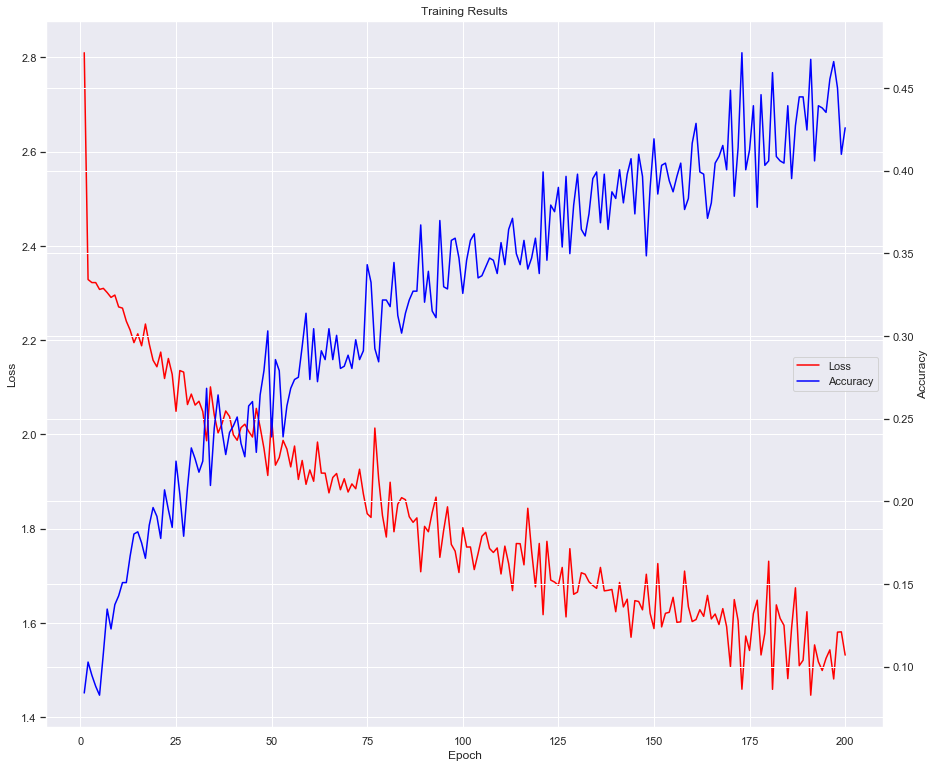

In [74]:
# Plot training results
history_df = pd.DataFrame(history.history,
                          index=range(1, len(history.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Results")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [75]:
# Evaluate model
model.evaluate(X_test, y_test)  # Likely overfitting: 0.6 training accuracy -> 0.34 testing accuracy

8/8 [==============================] - 0s 25ms/step - loss: 2.3845 - accuracy: 0.2400


[2.3844616413116455, 0.23999999463558197]

In [88]:
nn_pred_probs = model.predict(X_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)
results = pd.DataFrame({
    "Prediction": nn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,1,0
1,4,7
2,7,6
3,5,5
4,7,9
...,...,...
245,1,6
246,7,7
247,2,8
248,7,7


In [85]:
classification_report_nn = sklearn.metrics.classification_report(y_test, nn_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_nn[str(i)]
total_accuracy = classification_report_nn["accuracy"]
common_metrics = {"macro avg": classification_report_nn["macro avg"],
                  "weighted avg": classification_report_nn["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [90]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.24


In [91]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_nn.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [92]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()